In [3]:
# -*- coding: utf-8 -*-
"""READ DATA
简化版：读取 NetCDF 文件并输出 lat/lon/time 基本信息
- 使用 xarray 新写法：decode_times=CFDatetimeCoder(use_cftime=True)
- 更稳健的坐标识别（兼容 lat/lon/latitude/longitude/nav_lat/nav_lon 等）
- 统一字符串化时间，兼容 numpy.datetime64 与 cftime 对象
- 使用 with 上下文自动关闭文件句柄
"""

from pathlib import Path
import xarray as xr

# ========== 用户可改区域 ==========
# 文件目录
DATA_DIR = Path(r"D:\cangku\data")

# 目标文件列表
FILES = [
    "gpp_CanESM5_abrupt-4xCO2_185001-194912_1x1.nc",
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
]
# =================================

def _format_time_value(v) -> str:
    """将时间值安全地转为字符串，兼容 cftime 与 numpy.datetime64。"""
    try:
        return str(v)
    except Exception:
        try:
            # 某些 cftime 对象可以 .isoformat()
            return v.isoformat()
        except Exception:
            return repr(v)

def _first_last_as_str(da) -> str:
    """将时间坐标的首尾值格式化为 'first → last'。"""
    if da.size == 0:
        return "(empty)"
    first = _format_time_value(da.values[0])
    last = _format_time_value(da.values[-1])
    return f"{first} → {last}"

def _find_coord_name(ds: xr.Dataset, candidates) -> str | None:
    """
    在 ds.coords 中优先匹配候选名；若找不到，再到数据变量中用 attrs 判断。
    返回匹配到的名字或 None。
    """
    # 1) 直接在坐标名里找
    lower_map = {name.lower(): name for name in ds.coords}
    for cand in candidates:
        if cand in lower_map:
            return lower_map[cand]

    # 2) 有些文件把经纬度放到 data_vars，尝试通过 attributes 判断
    for var in list(ds.coords) + list(ds.data_vars):
        v = ds[var]
        std = (v.attrs.get("standard_name", "") or "").lower()
        longn = (v.attrs.get("long_name", "") or "").lower()
        units = (v.attrs.get("units", "") or "").lower()
        # 简单的启发式判断
        if any(k in std for k in ["latitude"]) or any(k in longn for k in ["latitude"]) or units in ("degrees_north", "degree_north"):
            if "lat" in candidates[0]:  # 粗略判断是否在找 lat
                return var
        if any(k in std for k in ["longitude"]) or any(k in longn for k in ["longitude"]) or units in ("degrees_east", "degree_east"):
            if "lon" in candidates[0]:  # 粗略判断是否在找 lon
                return var
    return None

def get_basic_info(path: Path) -> dict:
    """
    打开 NetCDF 并提取基本信息:
      - lat / lon 名称与形状
      - time 名称、长度与范围
    使用新 API：decode_times=CFDatetimeCoder(use_cftime=True) 以支持 360_day / noleap 等日历。
    """
    info = {}
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

    # 使用 with 自动关闭
    with xr.open_dataset(path, decode_times=time_coder) as ds:
        # 统一小写对比
        coord_names_lower = [c.lower() for c in ds.coords]
        # 尝试找到 lat / lon / time
        lat_candidates = ["lat", "latitude", "nav_lat", "y"]
        lon_candidates = ["lon", "longitude", "nav_lon", "x"]
        time_candidates = ["time"]

        # 转成小写构造候选集
        lat_name = _find_coord_name(ds, lat_candidates)
        lon_name = _find_coord_name(ds, lon_candidates)

        # time 相对固定，直接找
        time_name = None
        for c in ds.coords:
            if c.lower() in time_candidates or "time" in c.lower():
                time_name = c
                break

        # 填写 info
        if lat_name is not None and lat_name in ds:
            info["lat_name"] = lat_name
            info["lat_shape"] = tuple(ds[lat_name].shape)
        else:
            info["lat_name"] = None
            info["lat_shape"] = None

        if lon_name is not None and lon_name in ds:
            info["lon_name"] = lon_name
            info["lon_shape"] = tuple(ds[lon_name].shape)
        else:
            info["lon_name"] = None
            info["lon_shape"] = None

        if time_name is not None and time_name in ds:
            t = ds[time_name]
            info["time_name"] = time_name
            info["time_len"] = int(t.size)
            info["time_range"] = _first_last_as_str(t)
        else:
            info["time_name"] = None
            info["time_len"] = 0
            info["time_range"] = "(not found)"

    return info

def main():
    print("=== 基本信息检查开始 ===")
    base = Path(DATA_DIR)
    for fname in FILES:
        path = base / fname
        if not path.exists():
            print(f"[缺失] {fname}")
            continue

        try:
            info = get_basic_info(path)
            print(f"\n文件: {fname}")
            print(f"  lat:  {info.get('lat_name')}    shape={info.get('lat_shape')}")
            print(f"  lon:  {info.get('lon_name')}    shape={info.get('lon_shape')}")
            print(f"  time: {info.get('time_name')}   len={info.get('time_len')}")
            print(f"  time_range: {info.get('time_range')}")
        except Exception as e:
            print(f"[错误] 读取 {fname} 失败：{e}")

    print("\n=== 完成 ===")

if __name__ == "__main__":
    main()


=== 基本信息检查开始 ===

文件: gpp_CanESM5_abrupt-4xCO2_185001-194912_1x1.nc
  lat:  lat    shape=(180,)
  lon:  lon    shape=(360,)
  time: time   len=1200
  time_range: 1850-01-16 12:00:00 → 1949-12-16 12:00:00

文件: gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc
  lat:  lat    shape=(64,)
  lon:  lon    shape=(128,)
  time: time   len=1812
  time_range: 1850-01-16 12:00:00 → 2000-12-16 12:00:00

文件: gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc
  lat:  lat    shape=(64,)
  lon:  lon    shape=(128,)
  time: time   len=1200
  time_range: 1850-01-16 12:00:00 → 1949-12-16 12:00:00

文件: gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc
  lat:  lat    shape=(64,)
  lon:  lon    shape=(128,)
  time: time   len=1200
  time_range: 1850-01-15 00:00:00 → 1949-12-15 00:00:00

文件: tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc
  lat:  latitude    shape=(291, 360)
  lon:  longitude    shape=(291, 360)
  time: time   len=1812
  time_range: 1850-01-16 12:00:00 → 2000-12-16 12

In [1]:
# -*- coding: utf-8 -*-
"""REGRID (clean version)
插值 6 个 NetCDF 文件到 1°×1° 网格，并打印 lat/lon/time 基本信息
- 自动过滤掉辅助变量，只保留 gpp/tos + time + lat/lon
- GPP 文件 (lat/lon 是 1D)，直接 interp
- TOS 文件 (latitude/longitude 是 2D)，压缩成 1D 再 interp
- 对大文件 (tos abrupt, time>1500)，分块插值避免内存爆掉
"""

from pathlib import Path
import numpy as np
import xarray as xr

# ===== 用户可改区域 =====
DATA_DIR = Path(r"D:\cangku\data")
FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc",
]
# =======================

# 目标网格
target_lons = np.arange(0, 360, 1)
target_lats = np.arange(-90, 90, 1)

def fix_lon(lon):
    """把经度范围转到 0–360"""
    lon = np.where(lon < 0, lon + 360, lon)
    lon = np.where(lon >= 360, lon - 360, lon)
    return lon

def preprocess_latlon(ds, lat_name, lon_name):
    """统一处理经纬度，TOS 用二维压缩"""
    lat = ds[lat_name]
    lon = ds[lon_name]

    if lat.ndim == 2 and lon.ndim == 2:
        # === TOS 情况 ===
        lat_1d = lat[:, 0].values
        lon_1d = lon[0, :].values
        lon_1d = fix_lon(lon_1d)

        # 丢掉原始 2D lat/lon
        ds = ds.drop_vars([lat_name, lon_name], errors="ignore")

        # 把 (time,j,i) -> (time,lat,lon)
        for v in list(ds.data_vars):
            if {"j", "i"}.issubset(ds[v].dims):
                ds[v] = ds[v].rename({"j": "lat", "i": "lon"})

        # 添加坐标
        ds = ds.assign_coords(lat=("lat", lat_1d),
                              lon=("lon", lon_1d))
    else:
        # === GPP 情况 ===
        ds = ds.rename({lat_name: "lat", lon_name: "lon"})
        ds = ds.assign_coords(lon=fix_lon(ds["lon"].values))

    # 按经度排序，避免乱序
    ds = ds.sortby("lon")
    return ds

def get_latlon_names(ds):
    lat_name, lon_name = None, None
    for cand in ["lat", "latitude", "nav_lat", "y"]:
        if cand in ds.variables:
            lat_name = cand
            break
    for cand in ["lon", "longitude", "nav_lon", "x"]:
        if cand in ds.variables:
            lon_name = cand
            break
    if lat_name is None or lon_name is None:
        raise ValueError("无法识别经纬度变量名")
    return lat_name, lon_name

def print_basic_info(ds, fname):
    print(f"\n文件: {fname}")
    for v in ds.data_vars:
        print(f"  变量: {v}, shape={ds[v].shape}, dims={ds[v].dims}, dtype={ds[v].dtype}")
    if "lat" in ds.coords:
        print(f"  lat: shape={ds['lat'].shape}, range={ds['lat'].values[0]} → {ds['lat'].values[-1]}")
    if "lon" in ds.coords:
        print(f"  lon: shape={ds['lon'].shape}, range={ds['lon'].values[0]} → {ds['lon'].values[-1]}")
    if "time" in ds.coords:
        t = ds["time"]
        print(f"  time: len={t.size}, range={t.values[0]} → {t.values[-1]}")

def regrid_one(path: Path):
    with xr.open_dataset(path) as ds:
        # 识别经纬度
        lat_name, lon_name = get_latlon_names(ds)

        # ⭐ 只保留主要变量 (gpp/tos) + 坐标 ⭐
        if "gpp" in ds.data_vars:
            ds = ds[["gpp", "time", lat_name, lon_name]]
        elif "tos" in ds.data_vars:
            ds = ds[["tos", "time", lat_name, lon_name]]
        else:
            raise ValueError("未找到 gpp 或 tos 变量")

        # 经纬度预处理
        ds = preprocess_latlon(ds, lat_name, lon_name)

        # 插值
        if "tos" in path.name and ds.sizes["time"] > 1500:
            print(f"  [分块插值] {path.name}")
            chunks = []
            time_chunks = [
                slice("1850-01-01", "1900-12-31"),
                slice("1901-01-01", "1950-12-31"),
                slice("1951-01-01", "2000-12-31"),
            ]
            for tsel in time_chunks:
                ds_sel = ds.sel(time=tsel)
                ds_out_chunk = ds_sel.interp(
                    lon=target_lons,
                    lat=target_lats,
                    method="linear"
                )
                chunks.append(ds_out_chunk)
            ds_out = xr.concat(chunks, dim="time")
            ds_out = ds_out.sortby("time")
        else:
            ds_out = ds.interp(
                lon=target_lons,
                lat=target_lats,
                method="linear"
            )

    out_path = path.with_name(path.stem + "_1x1.nc")
    ds_out.to_netcdf(out_path)
    print(f"[完成] {path.name} -> {out_path.name}")
    print_basic_info(ds_out, out_path.name)

def main():
    for fname in FILES:
        path = DATA_DIR / fname
        if path.exists():
            try:
                regrid_one(path)
            except Exception as e:
                print(f"[错误] {fname}: {e}")
        else:
            print(f"[缺失] {fname}")

if __name__ == "__main__":
    main()


[完成] gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012.nc -> gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc

文件: gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc
  变量: gpp, shape=(1812, 180, 360), dims=('time', 'lat', 'lon'), dtype=float64
  lat: shape=(180,), range=-90 → 89
  lon: shape=(360,), range=0 → 359
  time: len=1812, range=1850-01-16 12:00:00 → 2000-12-16 12:00:00
[完成] gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912.nc -> gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc

文件: gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc
  变量: gpp, shape=(1200, 180, 360), dims=('time', 'lat', 'lon'), dtype=float64
  lat: shape=(180,), range=-90 → 89
  lon: shape=(360,), range=0 → 359
  time: len=1200, range=1850-01-16 12:00:00 → 1949-12-16 12:00:00
[完成] gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912.nc -> gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc

文件: gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc
  变量: gpp, shap

In [8]:
# PRINT DATA INFORMATION
import xarray as xr
from pathlib import Path

DATA_DIR = Path(r"D:\cangku\data")

FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
]

def main():
    for fname in FILES:
        path = DATA_DIR / fname
        if not path.exists():
            print(f"[缺失] {fname}")
            continue

        with xr.open_dataset(path) as ds:
            print(f"\n=== {path.name} ===")
            for v in ds.data_vars:
                print(f"{v}: dims={ds[v].dims}, dtype={ds[v].dtype}")
            print("coords:", list(ds.coords))
            # 时间信息
            if "time" in ds.coords:
                t = ds["time"]
                print(f"time: len={t.size}, type={t.dtype}, first={t.values[0]}, last={t.values[-1]}")

if __name__ == "__main__":
    main()



=== gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc ===
gpp: dims=('time', 'lat', 'lon'), dtype=float64
coords: ['time', 'lon', 'lat']
time: len=1812, type=object, first=1850-01-16 12:00:00, last=2000-12-16 12:00:00

=== gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc ===
gpp: dims=('time', 'lat', 'lon'), dtype=float64
coords: ['time', 'lon', 'lat']
time: len=1200, type=object, first=1850-01-16 12:00:00, last=1949-12-16 12:00:00

=== gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc ===
gpp: dims=('time', 'lat', 'lon'), dtype=float64
coords: ['time', 'lon', 'lat']
time: len=1200, type=object, first=1850-01-15 00:00:00, last=1949-12-15 00:00:00

=== tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc ===
tos: dims=('time', 'lat', 'lon'), dtype=float64
coords: ['time', 'j', 'i', 'lon', 'lat']
time: len=1812, type=object, first=1850-01-16 12:00:00, last=2000-12-16 12:00:00

=== tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc ===
tos: dims=('t

In [2]:
# -*- coding: utf-8 -*-
"""DETREND
对 6 个插值后的文件：
1. 截取 1850-1949 (1200 months)
2. 仅提取主要变量 (gpp 或 tos)
3. 定义索引数组 XXXX = 1..1200
4. 沿 time 方向做线性去趋势
5. 保存结果 (_1850-1949_detrend.nc)
"""

import xarray as xr
import numpy as np
from pathlib import Path

DATA_DIR = Path(r"D:\cangku\data")

FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
]

# 1D 索引数组 1..1200
XXXX = np.arange(1, 1201, dtype="float64")

def detrend_3d(data):
    """
    输入: data (time, lat, lon) -> numpy array
    输出: 去趋势后的 data (time, lat, lon)
    """
    t, nlat, nlon = data.shape
    out = np.full_like(data, np.nan, dtype="float64")

    for i in range(nlat):
        for j in range(nlon):
            y = data[:, i, j]
            if np.all(np.isnan(y)):
                continue
            mask = np.isfinite(y)
            if mask.sum() > 1:
                p = np.polyfit(XXXX[mask], y[mask], 1)
                trend = np.polyval(p, XXXX)
                out[:, i, j] = y - trend
    return out

def process_one(path: Path):
    with xr.open_dataset(path) as ds:
        # 识别主要变量 gpp/tos
        main_var = None
        for cand in ["gpp", "tos"]:
            if cand in ds.data_vars:
                main_var = cand
                break
        if main_var is None:
            print(f"[跳过] {path.name}: 没找到 gpp 或 tos")
            return

        # 裁剪时间 1850-1949
        da = ds[main_var].sel(time=slice("1850-01-01", "1949-12-31")).astype("float64")

        # 转 numpy (time, lat, lon)
        data = da.values
        if da.dims != ("time", "lat", "lon"):
            raise ValueError(f"{main_var} 维度顺序异常: {da.dims}")

        # 去趋势
        detrended = detrend_3d(data)

        # 转回 DataArray
        da_dt = xr.DataArray(
            detrended,
            coords={"time": da["time"], "lat": da["lat"], "lon": da["lon"]},
            dims=("time", "lat", "lon"),
            name=main_var,
            attrs=da.attrs,
        )

        # 存储
        out_path = path.with_name(path.stem + "_1850-1949_detrend.nc")
        da_dt.to_netcdf(out_path)
        print(f"[完成] {path.name} -> {out_path.name}")

def main():
    for fname in FILES:
        path = DATA_DIR / fname
        if path.exists():
            try:
                process_one(path)
            except Exception as e:
                print(f"[错误] {fname}: {e}")
        else:
            print(f"[缺失] {fname}")

if __name__ == "__main__":
    main()


[完成] gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc -> gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1850-1949_detrend.nc
[完成] gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc -> gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1850-1949_detrend.nc
[完成] gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc -> gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1850-1949_detrend.nc
[完成] tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc -> tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1850-1949_detrend.nc
[完成] tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc -> tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1850-1949_detrend.nc
[完成] tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc -> tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1850-1949_detrend.nc


In [23]:
# -*- coding: utf-8 -*-
"""DETREND (1890–1949)
对 6 个插值后的文件：
1. 截取 1890-1949 (720 months)
2. 仅提取主要变量 (gpp 或 tos)
3. 定义索引数组 XXXX = 1..720
4. 沿 time 方向做线性去趋势
5. 保存结果 (_1890-1949_detrend.nc)
"""

import xarray as xr
import numpy as np
from pathlib import Path

DATA_DIR = Path(r"D:\cangku\data")

FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc",
]

# 1D 索引数组 1..720 (1890–1949 共 60 年 × 12 月)
XXXX = np.arange(1, 721, dtype="float64")

def detrend_3d(data):
    """
    输入: data (time, lat, lon) -> numpy array
    输出: 去趋势后的 data (time, lat, lon)
    """
    t, nlat, nlon = data.shape
    out = np.full_like(data, np.nan, dtype="float64")

    for i in range(nlat):
        for j in range(nlon):
            y = data[:, i, j]
            if np.all(np.isnan(y)):
                continue
            mask = np.isfinite(y)
            if mask.sum() > 1:
                p = np.polyfit(XXXX[mask], y[mask], 1)
                trend = np.polyval(p, XXXX)
                out[:, i, j] = y - trend
    return out

def process_one(path: Path):
    with xr.open_dataset(path) as ds:
        # 识别主要变量 gpp/tos
        main_var = None
        for cand in ["gpp", "tos"]:
            if cand in ds.data_vars:
                main_var = cand
                break
        if main_var is None:
            print(f"[跳过] {path.name}: 没找到 gpp 或 tos")
            return

        # 裁剪时间 1890-1949
        da = ds[main_var].sel(time=slice("1890-01-01", "1949-12-31")).astype("float64")

        # 转 numpy (time, lat, lon)
        data = da.values
        if da.dims != ("time", "lat", "lon"):
            raise ValueError(f"{main_var} 维度顺序异常: {da.dims}")

        # 去趋势
        detrended = detrend_3d(data)

        # 转回 DataArray
        da_dt = xr.DataArray(
            detrended,
            coords={"time": da["time"], "lat": da["lat"], "lon": da["lon"]},
            dims=("time", "lat", "lon"),
            name=main_var,
            attrs=da.attrs,
        )

        # 存储
        out_path = path.with_name(path.stem + "_1890-1949_detrend.nc")
        da_dt.to_netcdf(out_path)
        print(f"[完成] {path.name} -> {out_path.name}")

def main():
    for fname in FILES:
        path = DATA_DIR / fname
        if path.exists():
            try:
                process_one(path)
            except Exception as e:
                print(f"[错误] {fname}: {e}")
        else:
            print(f"[缺失] {fname}")

if __name__ == "__main__":
    main()


[完成] gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc -> gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc
[完成] gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc -> gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc
[完成] gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc -> gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc
[完成] tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1.nc -> tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc
[完成] tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1.nc -> tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc
[完成] tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1.nc -> tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc


In [24]:
# -*- coding: utf-8 -*-
import xarray as xr
from pathlib import Path

DATA_DIR = Path(r"D:\cangku\data")

FILES = [
    "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
]

def check_file(path):
    with xr.open_dataset(path) as ds:
        print(f"\n=== {path.name} ===")
        if "lat" in ds.coords:
            print(f"lat: len={ds['lat'].size}, range={ds['lat'].values[0]} → {ds['lat'].values[-1]}")
        if "lon" in ds.coords:
            print(f"lon: len={ds['lon'].size}, range={ds['lon'].values[0]} → {ds['lon'].values[-1]}")
        if "time" in ds.coords:
            t = ds["time"]
            print(f"time: len={t.size}, range={t.values[0]} → {t.values[-1]}")

def main():
    for fname in FILES:
        path = DATA_DIR / fname
        if path.exists():
            check_file(path)
        else:
            print(f"[缺失] {fname}")

if __name__ == "__main__":
    main()



=== gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc ===
lat: len=180, range=-90 → 89
lon: len=360, range=0 → 359
time: len=720, range=1890-01-16 12:00:00 → 1949-12-16 12:00:00

=== gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc ===
lat: len=180, range=-90 → 89
lon: len=360, range=0 → 359
time: len=720, range=1890-01-16 12:00:00 → 1949-12-16 12:00:00

=== gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc ===
lat: len=180, range=-90 → 89
lon: len=360, range=0 → 359
time: len=720, range=1890-01-15 00:00:00 → 1949-12-15 00:00:00

=== tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc ===
lat: len=180, range=-90 → 89
lon: len=360, range=0 → 359
time: len=720, range=1890-01-16 12:00:00 → 1949-12-16 12:00:00

=== tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc ===
lat: len=180, range=-90 → 89
lon: len=360, range=0 → 359
time: len=720, range=1890-01-16 12:0

[完成] abrupt-4xCO2
[完成] G1
[完成] piControl
[输出完成] D:\cangku\data\enso_indices_1890-1949.nc
[图像已保存] D:\cangku\data\nino34_1890-1949.png


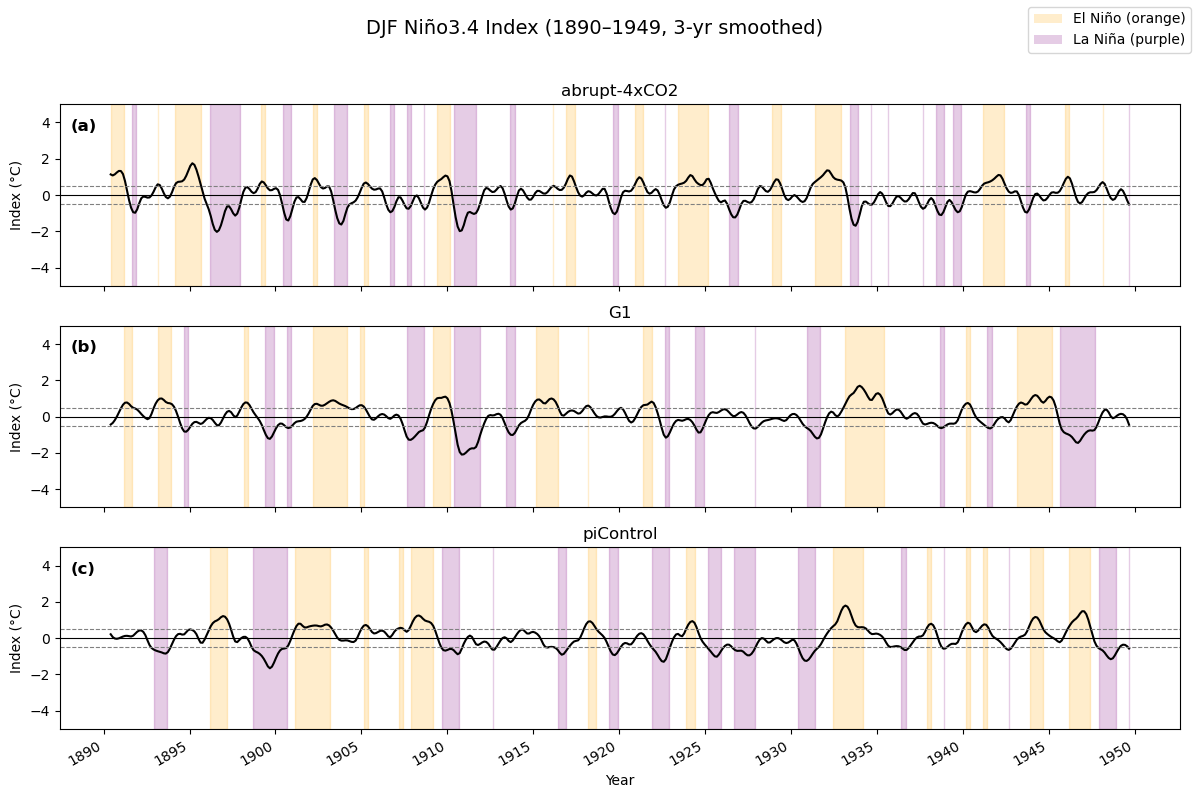

In [6]:
# -*- coding: utf-8 -*-
"""
计算三个试验 (abrupt-4xCO2, G1, piControl) 的 DJF Niño3.4 指数
- 时间: 1850–1949
- 平滑: 3 年滑动平均
- 存储 ENSO 指数 + ENSO 相位 (1=El Niño, -1=La Niña, 0=Neutral) 到 nc 文件
- 绘制平滑曲线 + ENSO 阈值填色 (每个试验一个子图)
"""

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from pathlib import Path
import matplotlib.dates as mdates
from matplotlib.patches import Patch

DATA_DIR = Path(r"D:\cangku\data")

FILES = {
    "abrupt-4xCO2": "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "G1": "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "piControl": "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
}

lat_range = slice(-5, 5)
lon_range = slice(190, 240)

def compute_nino34_index(fname):
    ds = xr.open_dataset(DATA_DIR / fname)
    tos = ds["tos"].sel(lat=lat_range, lon=lon_range)

    # 区域平均 (cos(lat) 加权)
    weights = np.cos(np.deg2rad(tos.lat))
    tos_mean = tos.weighted(weights).mean(dim=("lat", "lon"))

    # DJF 平均 (以12月为季度起点)
    tos_mean = tos_mean.resample(time="QS-DEC").mean()
    tos_mean = tos_mean.sel(time=slice("1890-01-01", "1949-12-31"))

    # 距平
    anom = tos_mean - tos_mean.mean()

    # 3年滑动平均
    anom_smooth = anom.rolling(time=3, center=True).mean()
    return anom_smooth

def classify_enso(series):
    """El Niño=1, La Niña=-1, Neutral=0"""
    vals = series.values
    phase = np.zeros_like(vals, dtype=int)
    phase[vals > 1] = 1
    phase[vals < -1] = -1
    return xr.DataArray(phase, coords={"time": series.time}, dims="time")
def plot_nino34(indices):
    fig, axes = plt.subplots(len(indices), 1, figsize=(12, 8), sharex=True)
    if len(indices) == 1:
        axes = [axes]

    # 子图角标
    letters = ["(a)", "(b)", "(c)"]

    for i, (ax, (label, series)) in enumerate(zip(axes, indices.items())):
        t = series["time"].values
        y = series.values

        # 插值为平滑曲线
        mask = np.isfinite(y)
        x = t[mask].astype("datetime64[D]").astype(float)  # 转 float
        x_smooth = np.linspace(x.min(), x.max(), 500)
        spline = make_interp_spline(x, y[mask], k=3)
        y_smooth = spline(x_smooth)
        t_smooth = x_smooth.astype("datetime64[D]")

        ax.plot(t_smooth, y_smooth, color="black", linewidth=1.5)
        ax.set_ylim(-5, 5)
        ax.set_ylabel("Index (°C)")
        ax.set_title(label)

        # 背景填色：橙=El Niño；紫=La Niña
        ax.fill_between(
            t, -5, 5, where=y > 0.5,
            color="orange", alpha=0.2
        )
        ax.fill_between(
            t, -5, 5, where=y < -0.5,
            color="purple", alpha=0.2
        )

        ax.axhline(0, color="k", linewidth=0.8)
        ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
        ax.axhline(-0.5, color="gray", linestyle="--", linewidth=0.8)

        # 子图角标放在左上
        ax.text(0.01, 0.92, letters[i], transform=ax.transAxes,
                fontsize=12, fontweight="bold", va="top", ha="left")

    # x 轴每 5 年一个主刻度
    import matplotlib.dates as mdates
    axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig.autofmt_xdate()

    axes[-1].set_xlabel("Year")
    plt.suptitle("DJF Niño3.4 Index (1890–1949, 3-yr smoothed)", fontsize=14)

    # 图例（仅说明颜色含义）
    from matplotlib.patches import Patch
    handles = [
        Patch(facecolor="orange", alpha=0.2, label="El Niño (orange)"),
        Patch(facecolor="purple", alpha=0.2, label="La Niña (purple)")
    ]
    fig.legend(handles=handles, loc="upper right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 保存 PNG 文件
    out_png = DATA_DIR / "nino34_1890-1949.png"
    plt.savefig(out_png, dpi=300)
    print(f"[图像已保存] {out_png}")

    plt.show()
def main():
    indices = {}
    phases = {}
    for name, fname in FILES.items():
        try:
            series = compute_nino34_index(fname)
            indices[name] = series
            phases[name] = classify_enso(series)
            print(f"[完成] {name}")
        except Exception as e:
            print(f"[错误] {name}: {e}")

    # 存储到 nc 文件（变量名避免连字符，用下划线）
    ds_out = xr.Dataset({
        "nino34_abrupt_4xCO2": indices["abrupt-4xCO2"],
        "nino34_G1": indices["G1"],
        "nino34_piControl": indices["piControl"],
        "enso_phase_abrupt_4xCO2": phases["abrupt-4xCO2"],
        "enso_phase_G1": phases["G1"],
        "enso_phase_piControl": phases["piControl"],
    })
    out_path = DATA_DIR / "enso_indices_1890-1949.nc"
    ds_out.to_netcdf(out_path)
    print(f"[输出完成] {out_path}")

    # 绘图
    plot_nino34(indices)

if __name__ == "__main__":
    main()


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:35: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead.
Example usage:
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(decode_times=time_coder)

  ds = xr.open_dataset(DATA_DIR / fname, use_cftime=True)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:50: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  anom["time"] = anom.indexes["time"].to_datetimeindex()
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:50: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses 

[完成] abrupt-4xCO2
[完成] G1


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:50: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  anom["time"] = anom.indexes["time"].to_datetimeindex()
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:50: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  anom["time"] = anom.indexes["time"].to_datetimeindex()
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\3688188871.py:35: DeprecationWarning: Usage of 'use_cftime' as a kwarg is deprecated. Please pass a 'CFDatetimeCoder' instance initialized with 'use_cftime' to the 'decode_times' kwarg instead

[完成] piControl
[输出完成] D:\cangku\data\enso_indices_1890-1949_DJF_annual.nc
[图像已保存] D:\cangku\data\nino34_1890-1949_DJF_annual.png


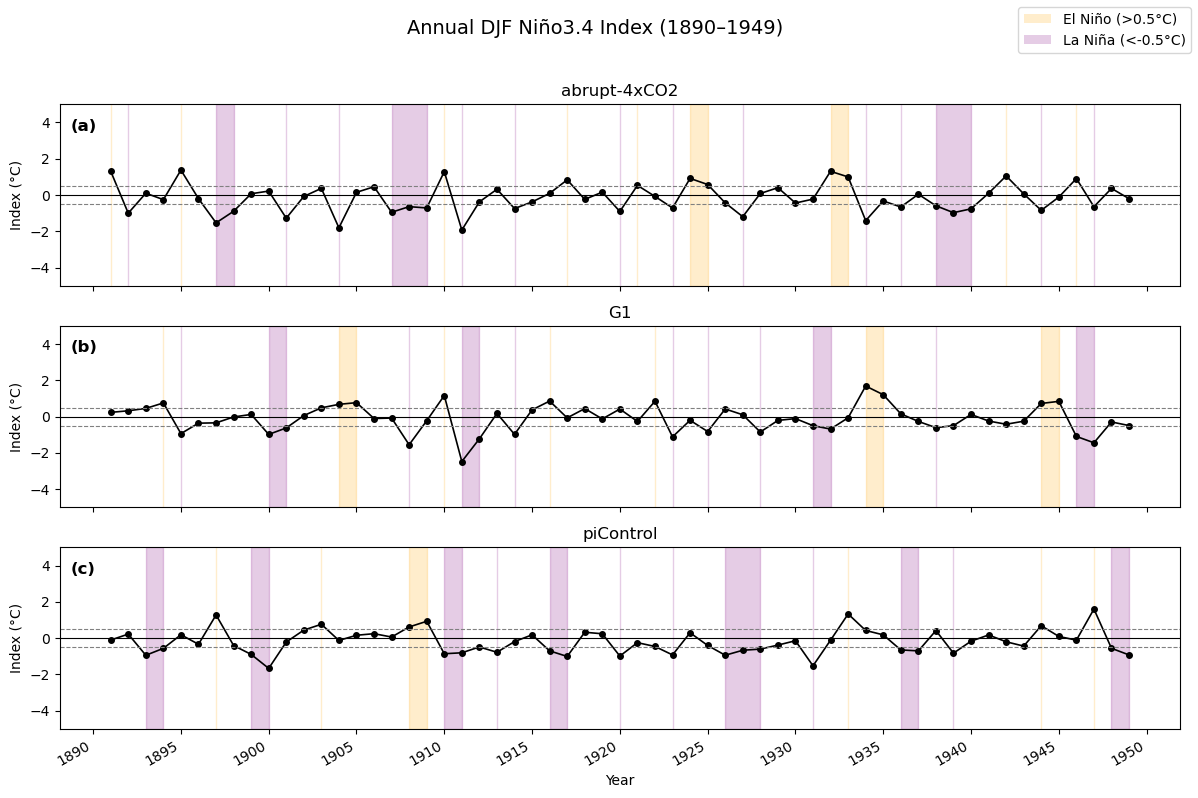

In [11]:
# -*- coding: utf-8 -*-
"""
计算三个试验 (abrupt-4xCO2, G1, piControl) 的年分辨率 DJF Niño3.4 指数
- 时间: 1890–1949
- ENSO 指数: 每年一个值（跨年 DJF 平均，前一年12月 + 当年1月 + 当年2月）
- ENSO 相位: ±0.5 ℃ 判定 (1=El Niño, -1=La Niña, 0=Neutral)
- 绘图: 折线图 + 黑点，每个试验一个子图
"""

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import pandas as pd

# 数据目录
DATA_DIR = Path(r"D:\cangku\data")

# 输入文件
FILES = {
    "abrupt-4xCO2": "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "G1": "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "piControl": "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
}

# Niño3.4 区域
lat_range = slice(-5, 5)
lon_range = slice(190, 240)


def compute_nino34_index(fname):
    """计算 Niño3.4 区域的年分辨率 DJF 距平指数"""
    ds = xr.open_dataset(DATA_DIR / fname, use_cftime=True)
    tos = ds["tos"].sel(lat=lat_range, lon=lon_range)

    # 区域平均 (cos(lat) 加权)
    weights = np.cos(np.deg2rad(tos.lat))
    tos_mean = tos.weighted(weights).mean(dim=("lat", "lon"))

    # 时间子集
    tos_mean = tos_mean.sel(time=slice("1889-12-01", "1949-02-28"))

    # 距平（基于全时期平均）
    anom = tos_mean - tos_mean.mean()

    # 把时间转为 pandas datetime（避免 cftime 精确匹配问题）
    anom = anom.copy()
    anom["time"] = anom.indexes["time"].to_datetimeindex()

    # 计算 DJF (跨年)
    years = np.arange(1890, 1950)  # 1890–1949
    djf_values = []
    for y in years:
        sel = anom.sel(time=slice(f"{y-1}-12-01", f"{y}-02-28"))
        if sel.size == 3:  # 确保有3个月
            djf_values.append(sel.mean().values)
        else:
            djf_values.append(np.nan)

    # 构建 DataArray（年分辨率）
    time_index = pd.to_datetime([f"{y}-01-01" for y in years])
    da = xr.DataArray(
        djf_values,
        coords={"time": time_index},
        dims="time",
        name="nino34"
    )

    return da



def classify_enso(series):
    """ENSO 相位分类: El Niño=1, La Niña=-1, Neutral=0 (阈值±0.5℃)"""
    vals = series.values
    phase = np.zeros_like(vals, dtype=int)
    phase[vals > 0.5] = 1
    phase[vals < -0.5] = -1
    return xr.DataArray(phase, coords={"time": series.time}, dims="time")


def plot_nino34(indices):
    """绘制 ENSO 指数折线图 + 黑点 + 背景填色"""
    fig, axes = plt.subplots(len(indices), 1, figsize=(12, 8), sharex=True)
    if len(indices) == 1:
        axes = [axes]

    letters = ["(a)", "(b)", "(c)"]

    for i, (ax, (label, series)) in enumerate(zip(axes, indices.items())):
        t = series["time"].values
        y = series.values

        # 折线图 + 黑点标记（每年一个点）
        ax.plot(t, y, color="black", linewidth=1.2, marker="o", markersize=4)

        ax.set_ylim(-5, 5)
        ax.set_ylabel("Index (°C)")
        ax.set_title(label)

        # 背景填色：橙=El Niño；紫=La Niña
        ax.fill_between(
            t, -5, 5, where=y > 0.5,
            color="orange", alpha=0.2
        )
        ax.fill_between(
            t, -5, 5, where=y < -0.5,
            color="purple", alpha=0.2
        )

        # 辅助线
        ax.axhline(0, color="k", linewidth=0.8)
        ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
        ax.axhline(-0.5, color="gray", linestyle="--", linewidth=0.8)

        # 子图角标
        ax.text(0.01, 0.92, letters[i], transform=ax.transAxes,
                fontsize=12, fontweight="bold", va="top", ha="left")

    # x 轴每 5 年一个主刻度
    axes[-1].xaxis.set_major_locator(mdates.YearLocator(5))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    fig.autofmt_xdate()

    axes[-1].set_xlabel("Year")
    plt.suptitle("Annual DJF Niño3.4 Index (1890–1949)", fontsize=14)

    # 图例
    handles = [
        Patch(facecolor="orange", alpha=0.2, label="El Niño (>0.5°C)"),
        Patch(facecolor="purple", alpha=0.2, label="La Niña (<-0.5°C)")
    ]
    fig.legend(handles=handles, loc="upper right")

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # 保存 PNG 文件
    out_png = DATA_DIR / "nino34_1890-1949_DJF_annual.png"
    plt.savefig(out_png, dpi=300)
    print(f"[图像已保存] {out_png}")

    plt.show()


def main():
    indices = {}
    phases = {}
    for name, fname in FILES.items():
        try:
            series = compute_nino34_index(fname)
            indices[name] = series
            phases[name] = classify_enso(series)
            print(f"[完成] {name}")
        except Exception as e:
            print(f"[错误] {name}: {e}")

    # 存储到 nc 文件
    ds_out = xr.Dataset({
        "nino34_abrupt_4xCO2": indices["abrupt-4xCO2"],
        "nino34_G1": indices["G1"],
        "nino34_piControl": indices["piControl"],
        "enso_phase_abrupt_4xCO2": phases["abrupt-4xCO2"],
        "enso_phase_G1": phases["G1"],
        "enso_phase_piControl": phases["piControl"],
    })
    out_path = DATA_DIR / "enso_indices_1890-1949_DJF_annual.nc"
    ds_out.to_netcdf(out_path)
    print(f"[输出完成] {out_path}")

    # 绘图
    plot_nino34(indices)


if __name__ == "__main__":
    main()


In [38]:
import xarray as xr
from pathlib import Path

# 文件路径
nc_file = Path(r"D:\cangku\data\enso_indices_1890-1949.nc")

# 打开文件
ds = xr.open_dataset(nc_file)

# 打印数据信息
print(ds)

# 如果想单独列出变量名
print("\n变量列表:", list(ds.data_vars))


<xarray.Dataset> Size: 13kB
Dimensions:                  (time: 240)
Coordinates:
  * time                     (time) object 2kB 1890-03-01 00:00:00 ... 1949-1...
Data variables:
    nino34_abrupt_4xCO2      (time) float64 2kB ...
    nino34_G1                (time) float64 2kB ...
    nino34_piControl         (time) float64 2kB ...
    enso_phase_abrupt_4xCO2  (time) int64 2kB ...
    enso_phase_G1            (time) int64 2kB ...
    enso_phase_piControl     (time) int64 2kB ...

变量列表: ['nino34_abrupt_4xCO2', 'nino34_G1', 'nino34_piControl', 'enso_phase_abrupt_4xCO2', 'enso_phase_G1', 'enso_phase_piControl']


In [14]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
from pathlib import Path

# 文件路径
DATA_DIR = Path(r"D:\cangku\data")
enso_file = DATA_DIR / "enso_indices_1890-1949.nc"

# 打开数据
ds = xr.open_dataset(enso_file)

# 检查三个实验
for var in ["nino34_abrupt_4xCO2", "nino34_G1", "nino34_piControl"]:
    da = ds[var]

    print(f"\n=== 检查 {var} ===")
    print("起始 5 个值:", da.values[:5])
    print("结束 5 个值:", da.values[-5:])

    # 检查是否有 NaN
    nan_count = np.isnan(da.values).sum()
    print("NaN 数量:", nan_count)

    # 简单看波动幅度
    diffs = np.diff(da.values)
    print("相邻年份差值范围:", diffs.min(), "→", diffs.max())



=== 检查 nino34_abrupt_4xCO2 ===
起始 5 个值: [       nan 1.13592998 1.15093152 1.33766678 1.0671477 ]
结束 5 个值: [-0.10494038  0.31236602  0.03111417 -0.52065366         nan]
NaN 数量: 2
相邻年份差值范围: nan → nan

=== 检查 nino34_G1 ===
起始 5 个值: [        nan -0.4383582  -0.17577718  0.27406064  0.6961277 ]
结束 5 个值: [ 0.01466198  0.14805897  0.05085122 -0.45261074         nan]
NaN 数量: 2
相邻年份差值范围: nan → nan

=== 检查 nino34_piControl ===
起始 5 个值: [        nan  0.21515178 -0.02331268  0.00093631  0.10264946]
结束 5 个值: [-0.81650554 -0.4468433  -0.36610046 -0.57335724         nan]
NaN 数量: 2
相邻年份差值范围: nan → nan


已保存到 D:\cangku\data\enso_djf_raw.nc

=== ENSO DJF 指数（前10年）===
<xarray.DataArray 'tos' (experiment: 3, year: 10)> Size: 240B
array([[ 1.31416019, -0.24582294, -0.04920716,  0.15238953,  0.89324464,
         0.9705024 , -1.73220193, -0.8080237 ,  0.32069707,  0.4820437 ],
       [ 0.23290202,  0.64567592,  0.06540358,  0.92659074, -0.41519999,
        -0.31021018, -0.28389847,  0.18168201,  0.57562228, -0.96092363],
       [-0.09815713,  0.1498462 , -0.09039724, -0.73843478,  0.23116816,
         0.06408099,  0.98722161,  0.25761594, -0.2764564 , -1.38768615]])
Coordinates:
  * year        (year) int64 80B 1891 1892 1893 1894 ... 1897 1898 1899 1900
  * experiment  (experiment) <U12 144B 'abrupt-4xCO2' 'G1' 'piControl'


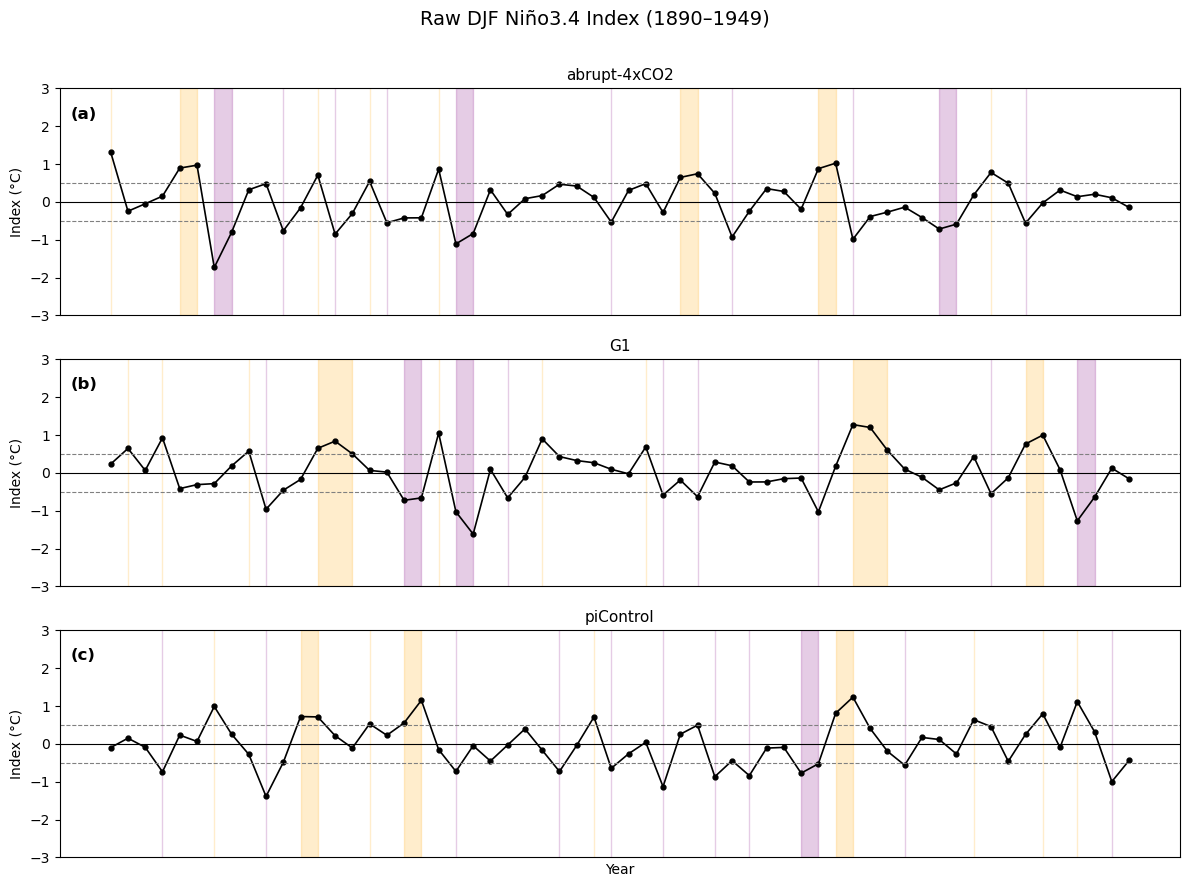

In [20]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

DATA_DIR = Path(r"D:\cangku\data")

tos_files = {
    "abrupt-4xCO2": DATA_DIR / "tos_Omon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "G1":           DATA_DIR / "tos_Omon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "piControl":    DATA_DIR / "tos_Omon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
}

def calc_nino34(path):
    """计算原始 DJF Niño3.4 指数"""
    ds = xr.open_dataset(path)
    tos = ds["tos"]

    # ✅ 修正纬度范围：lat 从 -90 → 89，所以要写 -5 到 5
    sub = tos.sel(lat=slice(-5, 5), lon=slice(190, 240))

    # 面积加权平均（cos(lat)）
    weights = np.cos(np.deg2rad(sub.lat))
    tos_n34 = sub.weighted(weights).mean(("lon", "lat"))

    # DJF 季节平均，QS-DEC = 每年12月起的季度
    tos_djf = tos_n34.resample(time="QS-DEC").mean()

    # 取 1890–1949
    tos_djf = tos_djf.sel(time=slice("1890-12", "1949-12"))

    # 调整年份：把DJF算到次年
    years = [t.dt.year.values + 1 for t in tos_djf.time]
    tos_djf = tos_djf.assign_coords(year=("time", years))

    # 按年重采样 → 每年一个值
    tos_djf = tos_djf.groupby("year").mean("time")

    return tos_djf

# 计算三个实验
enso_dict = {}
for exp, f in tos_files.items():
    enso_dict[exp] = calc_nino34(f)

# 合并
enso_djf = xr.concat(list(enso_dict.values()), dim="experiment")
enso_djf = enso_djf.assign_coords(experiment=list(enso_dict.keys()))

# 保存
out_path = DATA_DIR / "enso_djf_raw.nc"
enso_djf.to_netcdf(out_path)
print(f"已保存到 {out_path}")

# ✅ 输出前10年数据
print("\n=== ENSO DJF 指数（前10年）===")
print(enso_djf.isel(year=slice(0, 10)))

# ================== 绘图 ==================
fig, axes = plt.subplots(len(enso_djf.experiment), 1, figsize=(12, 9), sharex=True)

letters = ["(a)", "(b)", "(c)"]
for i, exp in enumerate(enso_djf.experiment.values):
    ax = axes[i]
    years = enso_djf.year.values
    y = enso_djf.sel(experiment=exp).values

    ax.plot(years, y, color="black", linewidth=1.2, marker="o", markersize=3.5)

    # ENSO 阈值填色
    ax.fill_between(years, -3, 3, where=y > 0.5, color="orange", alpha=0.2)
    ax.fill_between(years, -3, 3, where=y < -0.5, color="purple", alpha=0.2)

    # 辅助线
    ax.axhline(0, color="k", linewidth=0.8)
    ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8)
    ax.axhline(-0.5, color="gray", linestyle="--", linewidth=0.8)

    ax.set_ylim(-3, 3)
    ax.set_ylabel("Index (°C)")
    ax.set_title(exp, fontsize=11)

    ax.text(0.01, 0.92, letters[i], transform=ax.transAxes,
            fontsize=12, fontweight="bold", va="top", ha="left")

    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[-1].set_xlabel("Year")
plt.suptitle("Raw DJF Niño3.4 Index (1890–1949)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


[完成] abrupt-4xCO2
[完成] G1
[完成] piControl
abrupt-4xCO2 60 [1890 1891 1892 1893 1894] ... [1945 1946 1947 1948 1949]
G1 60 [1890 1891 1892 1893 1894] ... [1945 1946 1947 1948 1949]
piControl 60 [1890 1891 1892 1893 1894] ... [1945 1946 1947 1948 1949]


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\2728228611.py:184: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=300)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\2728228611.py:184: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=300)
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2960\2728228611.py:184: UserWarning: Glyph 34394 (\N{CJK UNIFIED IDEOGRAPH-865A}) missing from font(s) DejaVu Sans.
  plt.savefig(out_png, dpi=300)


[图像已保存] D:\cangku\data\tropical_GPP_total_1890-1949.png


D:\miniconda\envs\research\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\miniconda\envs\research\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\miniconda\envs\research\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34394 (\N{CJK UNIFIED IDEOGRAPH-865A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


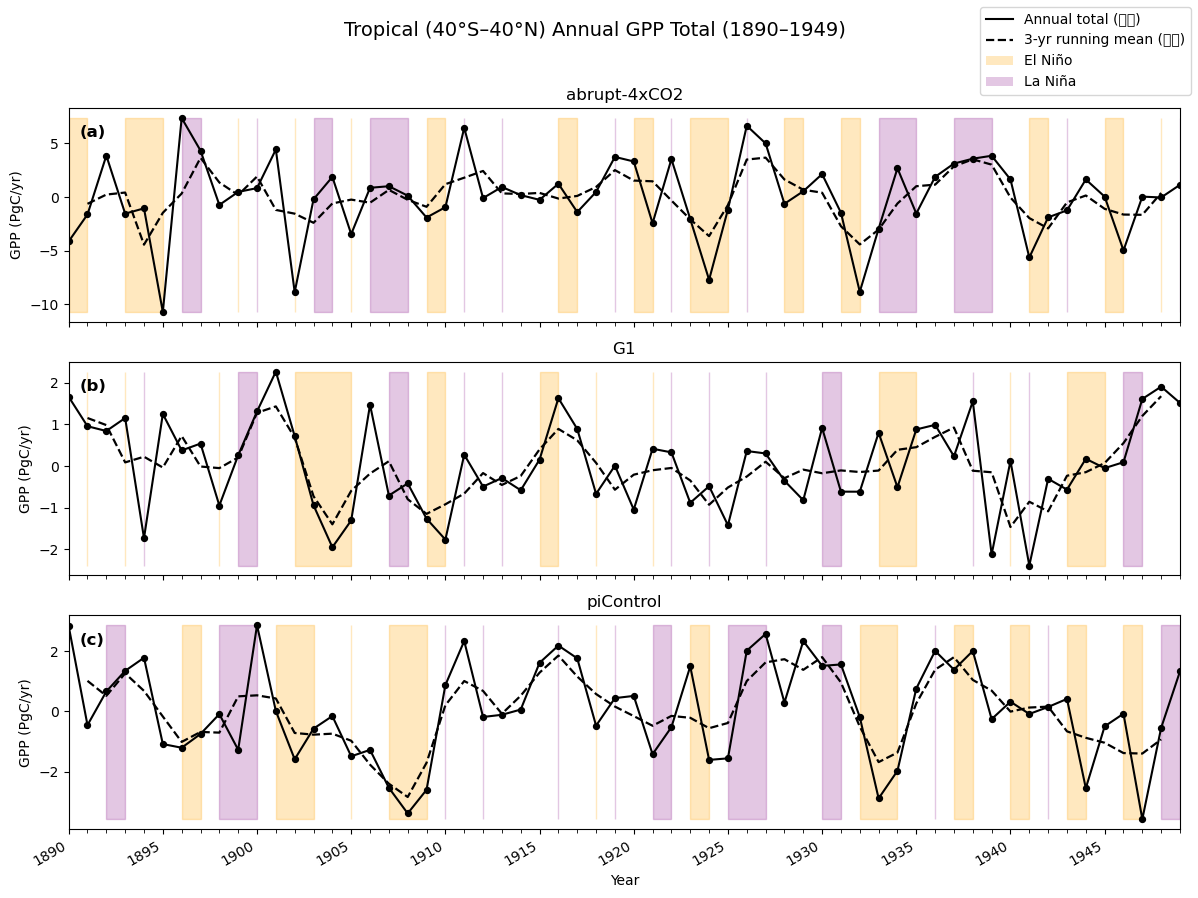

In [5]:
# -*- coding: utf-8 -*-
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from pathlib import Path
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

# ================== 路径配置 ==================
DATA_DIR = Path(r"D:\cangku\data")

FILES = {
    "abrupt-4xCO2": "gpp_Lmon_CanESM5_abrupt-4xCO2_r1i1p2f1_gn_185001-200012_1x1_1890-1949_detrend.nc",
    "G1":            "gpp_Lmon_CanESM5_G1_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
    "piControl":     "gpp_Lmon_CanESM5_piControl_r1i1p2f1_gn_185001-194912_1x1_1890-1949_detrend.nc",
}
AREA_FILE = DATA_DIR / "landarea_1x1.nc"            # 变量: area(lat,lon), 单位 m2
ENSO_FILE = DATA_DIR / "enso_indices_1890-1949.nc"
LAT_SLICE = slice(-40, 40)

# ================== 工具函数 ==================
def standardize_coords(ds):
    """统一经纬度命名为 lat/lon，且把经度转为 0..360 并排序。"""
    # 升级/重命名坐标
    if "latitude" in ds.coords: ds = ds.rename({"latitude": "lat"})
    if "longitude" in ds.coords: ds = ds.rename({"longitude": "lon"})
    if "latitude" in ds.dims and "lat" not in ds.dims: ds = ds.rename({"latitude":"lat"})
    if "longitude" in ds.dims and "lon" not in ds.dims: ds = ds.rename({"longitude":"lon"})
    # 经度到 0..360
    if "lon" in ds.coords and float(ds["lon"].min()) < 0:
        ds = ds.assign_coords(lon=(ds["lon"] % 360)).sortby("lon")
    return ds

def build_area_on_gpp_grid(area_path, gpp_ref_da):
    """
    将 area(lat,lon) 用最近邻插值对齐到 gpp(time,lat,lon) 的经纬网格。
    返回与 gpp 空间匹配的 area(lat,lon)。
    """
    ds_area = xr.open_dataset(area_path)
    # 重命名 area 变量（若名字不是 area，则抓唯一变量）
    if "area" not in ds_area.data_vars:
        if len(ds_area.data_vars) == 1:
            only = list(ds_area.data_vars)[0]
            ds_area = ds_area.rename({only: "area"})
        else:
            raise KeyError(f"{area_path} 未找到变量 'area' 且无法自动判定唯一变量。")
    ds_area = standardize_coords(ds_area)
    area = ds_area["area"]

    # 先裁剪热带（提升插值效率）
    area = area.sel(lat=LAT_SLICE)

    # 最近邻插值到 GPP 的经纬度网格
    area_matched = area.interp(
        lat=gpp_ref_da.lat, lon=gpp_ref_da.lon, method="nearest"
    )

    # 广播到 GPP 的空间维度形状
    area_matched = area_matched.broadcast_like(gpp_ref_da.isel(time=0))
    return area_matched

import xarray as xr
import numpy as np

def get_enso_year_map(enso_path, thr=0.5):
    """
    用 Niño3.4 指数直接判年：
      - 年内任一时间点 > +thr -> 1 (El Niño)
      - 年内任一时间点 < -thr -> -1 (La Niña)
      - 否则 -> 0 (Neutral)
    """
    ds = xr.open_dataset(enso_path)
    years = np.arange(1890, 1950)

    # 改为读取指数变量，而非相位变量
    mapping = {
        "abrupt-4xCO2": "nino34_abrupt_4xCO2",
        "G1":           "nino34_G1",
        "piControl":    "nino34_piControl",
    }

    out = {}
    for exp, var in mapping.items():
        idx = ds[var]
        year_map = {}
        for y in years:
            vals = idx.sel(time=str(y)).values
            if vals.size == 0 or np.all(np.isnan(vals)):
                year_map[y] = 0
            elif np.nanmax(vals) >  thr:
                year_map[y] = 1   # El Niño
            elif np.nanmin(vals) < -thr:
                year_map[y] = -1  # La Niña
            else:
                year_map[y] = 0
        out[exp] = year_map
    return out


# ================== 计算 PgC/年 ==================
def compute_annual_gpp_total(gpp_path, area_matched):
    ds = xr.open_dataset(gpp_path)
    ds = standardize_coords(ds)
    if "gpp" not in ds.data_vars:
        # 尝试抓唯一变量作为 gpp
        if len(ds.data_vars) == 1:
            only = list(ds.data_vars)[0]
            ds = ds.rename({only: "gpp"})
        else:
            raise KeyError(f"{gpp_path} 未找到变量 'gpp'，现有变量：{list(ds.data_vars)}")
    gpp = ds["gpp"].sel(lat=LAT_SLICE)  # 经度已标准化为 0..360

    # 面积对齐到当前文件的纬度/经度
    area_use = area_matched.sel(lat=gpp.lat, lon=gpp.lon)

    # 海洋格点面积置 0（假定海洋格点 gpp 为 NaN）
    area_use = xr.where(gpp.isel(time=0).isnull(), 0.0, area_use)

    # 每月天数（兼容 CFTime）
    days_in_month = gpp["time"].dt.days_in_month

    # 月总量：kg m-2 s-1 × m2 × (天×86400) = kg/月；→ PgC/月（×1e-12）
    monthly_total = (gpp * area_use * days_in_month * 86400).sum(("lat","lon")) * 1e-12*1e+6

    # 年度总量（历年 1–12 月）
    annual_total = monthly_total.resample(time="YS").sum().sel(time=slice("1890","1949"))
    return annual_total

# ================== 绘图 ==================
def plot_with_enso(gpp_annual_dict, enso_years, out_png):
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
    letters = ["(a)", "(b)", "(c)"]

    for i, (ax, (label, series)) in enumerate(zip(axes, gpp_annual_dict.items())):
        years = series["time.year"].values
        vals = series.values

        # 背景色：El Niño 橙，La Niña 紫
        y_min, y_max = np.nanmin(vals), np.nanmax(vals)
        enso = np.array([enso_years[label][y] for y in years])
        ax.fill_between(years, y_min, y_max, where=(enso == 1), color="orange", alpha=0.25, zorder=0)
        ax.fill_between(years, y_min, y_max, where=(enso == -1), color="purple", alpha=0.22, zorder=0)

        # 实线：年度真实值 + 每年黑点
        ax.plot(years, vals, color="black", linewidth=1.5, zorder=3)
        ax.scatter(years, vals, s=18, c="black", zorder=4)

        # 虚线：3 年滑动平均（中心对齐）
        smooth = series.rolling(time=3, center=True).mean()
        ax.plot(smooth["time.year"].values, smooth.values, linestyle="--", linewidth=1.6, color="black", zorder=2)

        ax.set_ylabel("GPP (PgC/yr)")
        ax.set_title(label)

        # 子图角标
        ax.text(0.01, 0.92, letters[i], transform=ax.transAxes,
                fontsize=12, fontweight="bold", va="top", ha="left")

        # x 轴每 5 年刻度
        #ax.xaxis.set_major_locator(mdates.YearLocator(5))
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                # —— x轴：直接用数值年份，并固定范围 1890–1949 —— #
        ax.set_xlim(1890, 1949)
        ax.xaxis.set_major_locator(mticker.MultipleLocator(5))    # 主刻度每 5 年
        ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))    # 次刻度每 1 年
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
        ax.tick_params(axis='x', which='minor', length=3)


    axes[-1].set_xlabel("Year")
    fig.autofmt_xdate()

    # —— 图例：线型 + 背景色 —— #
    line_real   = Line2D([0], [0], color="black", linewidth=1.5, label="Annual total (实线)")
    line_smooth = Line2D([0], [0], color="black", linestyle="--", linewidth=1.6, label="3-yr running mean (虚线)")
    patch_en    = Patch(facecolor="orange", alpha=0.25, label="El Niño")
    patch_ln    = Patch(facecolor="purple", alpha=0.22, label="La Niña")
    fig.legend(handles=[line_real, line_smooth, patch_en, patch_ln], loc="upper right")

    plt.suptitle("Tropical (40°S–40°N) Annual GPP Total (1890–1949)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(out_png, dpi=300)
    print(f"[图像已保存] {out_png}")
    plt.show()


# ================== 主流程 ==================
def main():
    # 用 abrupt-4xCO2 文件的网格做参考，构建对齐后的面积
    ds_ref = xr.open_dataset(DATA_DIR / FILES["abrupt-4xCO2"])
    ds_ref = standardize_coords(ds_ref)
    gpp_ref = ds_ref["gpp"].sel(lat=LAT_SLICE)
    area_matched = build_area_on_gpp_grid(AREA_FILE, gpp_ref)

    # 计算 3 个实验的年度总量
    gpp_annual = {}
    for name, relpath in FILES.items():
        gpp_path = DATA_DIR / relpath
        gpp_annual[name] = compute_annual_gpp_total(gpp_path, area_matched)
        print(f"[完成] {name}")
    for name, da in gpp_annual.items():
        print(name, da.time.size, da.time.dt.year.values[:5], '...', da.time.dt.year.values[-5:])

    # ENSO 年度分类
    enso_years = get_enso_year_map(ENSO_FILE)

    # 绘图
    out_png = DATA_DIR / "tropical_GPP_total_1890-1949.png"
    plot_with_enso(gpp_annual, enso_years, out_png)

if __name__ == "__main__":
    main()
